In [1]:
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# General data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow
tensorflow.random.set_seed(1234)

# Neural Net modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras import layers

In [2]:
cluster_candidates = pd.read_csv('/Users/steven/Documents/CPoint/data/pleiades_candidates.csv')
del cluster_candidates['Unnamed: 0']
del cluster_candidates['Unnamed: 0.1']
print(len(cluster_candidates))

cluster_candidates_rv = cluster_candidates[~cluster_candidates['radial_velocity'].isna()]
cluster_candidates_rv = cluster_candidates_rv[~cluster_candidates_rv['radial_velocity_error'].isna()]
cluster_candidates_rv.info()

1649
<class 'pandas.core.frame.DataFrame'>
Index: 557 entries, 0 to 1648
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       557 non-null    int64  
 1   source_id                   557 non-null    int64  
 2   ra                          557 non-null    float64
 3   ra_error                    557 non-null    float64
 4   dec                         557 non-null    float64
 5   dec_error                   557 non-null    float64
 6   l                           557 non-null    float64
 7   b                           557 non-null    float64
 8   parallax                    557 non-null    float64
 9   parallax_error              557 non-null    float64
 10  pmra                        557 non-null    float64
 11  pmra_error                  557 non-null    float64
 12  pmdec                       557 non-null    float64
 13  pmdec_error                 557 no

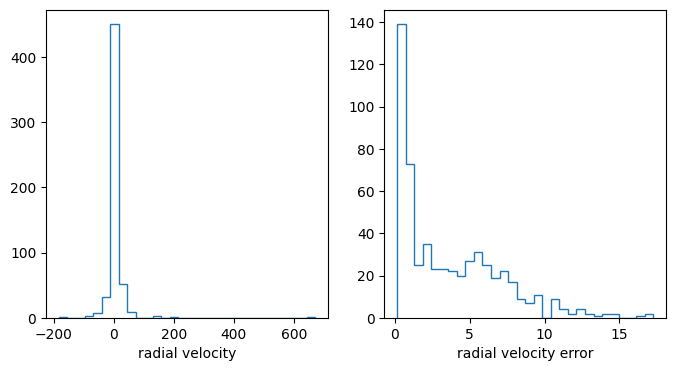

In [3]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
plt.xlabel('radial velocity')

plt.subplot(1,2,2)
plt.hist(cluster_candidates_rv['radial_velocity_error'], bins=30, histtype='step', density=False)
plt.xlabel('radial velocity error')
plt.show()

In [40]:
#x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec','parallax']])
x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec','parallax','radial_velocity_error']])
#x_data = np.array(cluster_candidates_rv[['l','b','pmra','pmdec','parallax']])

#y_data = np.array(cluster_candidates_rv[['radial_velocity','radial_velocity_error']])
y_data = np.array(cluster_candidates_rv[['radial_velocity']])

x_data.shape, y_data.shape

((557, 6), (557, 1))

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=42)

# use minMax scaler
#min_max_scaler = MinMaxScaler()
#x_train = min_max_scaler.fit_transform(x_train)
#x_test = min_max_scaler.transform(x_test)

print('Training shape:', x_train.shape, y_train.shape)
print('Testing shape:', x_test.shape, y_test.shape)

Training shape: (334, 6) (334, 1)
Testing shape: (223, 6) (223, 1)


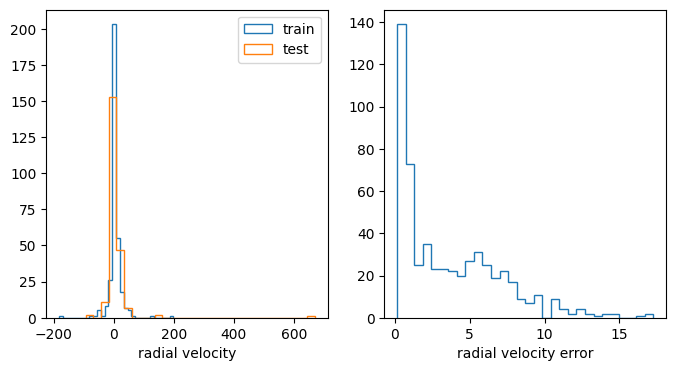

In [42]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(y_train, bins=30, density=False, histtype='step', label='train')
plt.hist(y_test, bins=30, density=False, histtype='step', label='test')
plt.legend()
plt.xlabel('radial velocity')

plt.subplot(1,2,2)
plt.hist(cluster_candidates_rv['radial_velocity_error'], bins=30, histtype='step', density=False)
plt.xlabel('radial velocity error')
plt.show()

In [43]:
tensorflow.keras.backend.clear_session()

In [44]:
# # build the model!
# model = Sequential()
# model.add(Dense(1000, input_shape=(x_train.shape[1],), activation='relu')) # (features,)
# model.add(Dropout(0.2))
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='linear')) # output node
# model.summary() # see what your model looks like
initializer = tensorflow.keras.initializers.glorot_uniform(seed=1)

# build the model!
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(32, activation='relu', kernel_initializer=initializer),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)                │        224 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │      2,112 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │      8,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 256)               │     33,024 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 1)                 │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 86,945 (339.63 KB)

 Trainable params: 86,945 (339.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 365.7737 - val_loss: 2230.2678
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 341.6752 - val_loss: 2251.3975
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 348.6269 - val_loss: 2245.7249
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 344.1118 - val_loss: 2244.8555
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 338.6028 - val_loss: 2250.5498
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 345.3831 - val_loss: 2247.1621
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 342.6494 - val_loss: 2251.3301
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 341.2806 - val_loss: 2244.0916
Epoch 9/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 339.1531 - val_loss: 2242.3586
Epoch 10/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 342.4529 - val_loss: 2242.2205
Epoch 11/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 342.2813 - val_loss: 2239.4553
Epoch 12/1

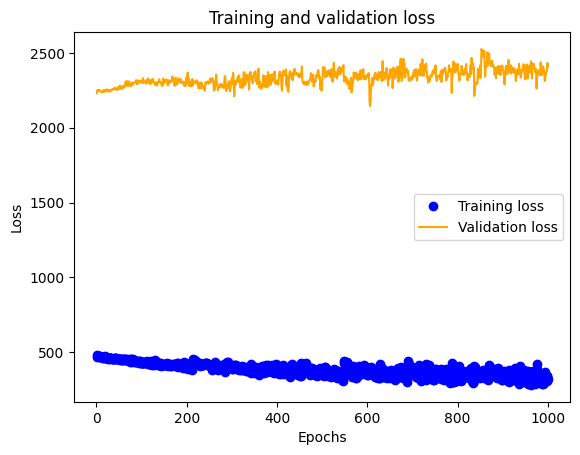

In [45]:
# compile the model
#model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='mse', metrics=['mae'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=custom_loss, metrics=['mae'])
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# early stopping callback
#es = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
#history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[es], epochs=500, batch_size=30, verbose=1)
history = model.fit(x_train, y_train, epochs=1000, batch_size=30, validation_data=(x_test, y_test), verbose=1)


history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


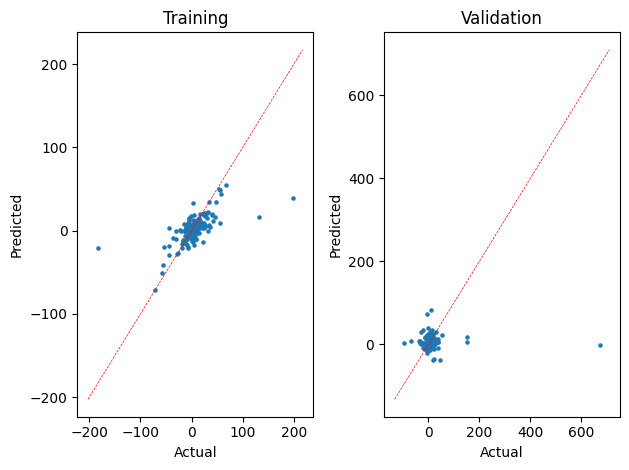

In [46]:
fig, axes = plt.subplots(1,2)
axes[0].scatter(x=y_train, y=model.predict(x_train), s=5)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)

axes[1].scatter(x=y_test, y=model.predict(x_test), s=5)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
fig.tight_layout()
plt.show()

In [47]:
# metrics
pred = model.predict(x_test)
pred

trainpreds = model.predict(x_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train
print(mean_absolute_error(y_test, pred)) # test

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
7.092839834146333
14.570581968088055
